## 도로 위험 등급별 강수량 통계 분석 및 시각화

위험 등급별 강수량 통계:
  RSK_ELMN_GRD  min_rain  max_rain  mean_rain  median_rain
0            E       0.5       1.0   0.599057          0.5
1            F       0.5       1.0   0.505132          0.5
2            G       3.0       4.0   3.283019          3.0
3            J       0.5       1.0   0.506410          0.5
4            L       3.0       5.0   3.329558          3.0

중앙값을 기준으로 한 강수량 경계:
E-F: 0.50mm
F-G: 1.75mm
G-J: 1.75mm
J-L: 1.75mm


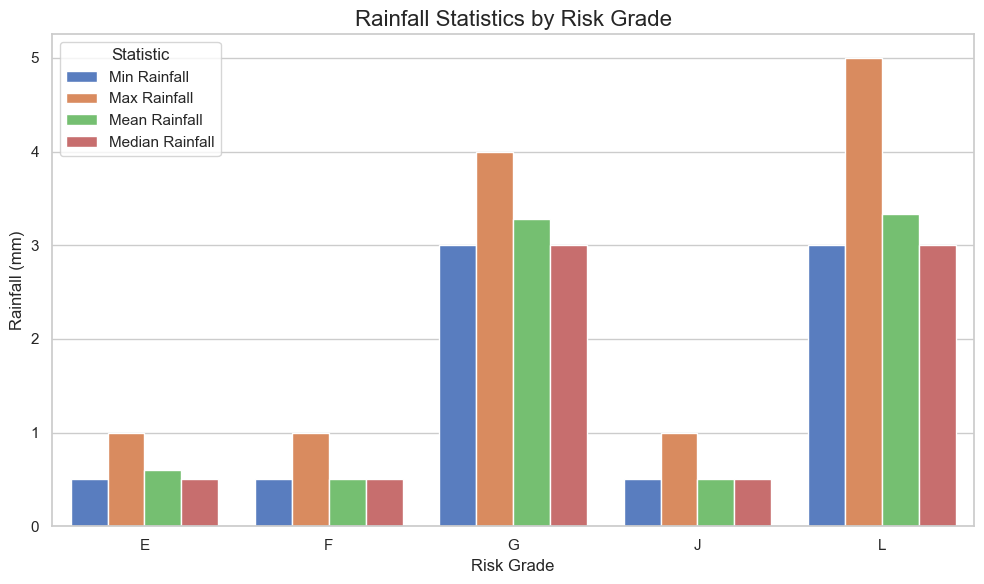

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows에서의 올바른 폰트 경로 사용
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 올바르게 표시되도록 설정

# 데이터셋 로드
df = pd.read_csv("도로위험상황예보.csv")

# 분석에 필요한 컬럼 선택
columns_of_interest = ["RSK_ELMN_GRD", "RN_1HR", "AIRTP", "LAT", "LOT"]
df = df[columns_of_interest]

# 위험 등급을 숫자 값으로 매핑
grade_mapping = {"E": 1, "F": 2, "G": 3, "J": 4, "L": 5}
inverse_mapping = {1: "E", 2: "F", 3: "G", 4: "J", 5: "L"}
df["RSK_ELMN_GRD"] = df["RSK_ELMN_GRD"].map(grade_mapping)

# RN_1HR을 숫자로 변환, 숫자가 아닌 값은 NaN으로 설정
df["RN_1HR"] = pd.to_numeric(df["RN_1HR"], errors="coerce")

# 'RN_1HR' 또는 'RSK_ELMN_GRD'에 결측치가 있는 행 삭제
df = df.dropna(subset=["RN_1HR", "RSK_ELMN_GRD"])

# 위험 등급별 강수량 통계 계산
rain_stats = df.groupby("RSK_ELMN_GRD")["RN_1HR"].agg(
    min_rain="min",
    max_rain="max",
    mean_rain="mean",
    median_rain="median"
).reset_index()

# 위험 등급을 다시 문자 값으로 매핑
rain_stats["RSK_ELMN_GRD"] = rain_stats["RSK_ELMN_GRD"].map(inverse_mapping)

# 중앙값을 기준으로 한 강수량 경계 계산
rain_boundaries = {}
for i in range(len(rain_stats) - 1):
    grade1, grade2 = rain_stats.iloc[i], rain_stats.iloc[i + 1]
    rain_boundaries[f"{grade1['RSK_ELMN_GRD']}-{grade2['RSK_ELMN_GRD']}"] = (
        grade1["median_rain"] + grade2["median_rain"]
    ) / 2

# 강수량 통계 출력
print("위험 등급별 강수량 통계:")
print(rain_stats)
print("\n중앙값을 기준으로 한 강수량 경계:")
for boundary, rain in rain_boundaries.items():
    print(f"{boundary}: {rain:.2f}mm")

# 위험 등급별 강수량 통계 시각화
sns.set(style="whitegrid")

# 각 위험 등급에 대한 강수량 통계 플롯
fig, ax = plt.subplots(figsize=(10, 6))

# 플롯에서 읽기 쉽게 컬럼 이름 변경
rain_name_mapping = {
    "min_rain": "Min Rainfall",
    "max_rain": "Max Rainfall",
    "mean_rain": "Mean Rainfall",
    "median_rain": "Median Rainfall"
}

rain_stats_long = rain_stats.rename(columns=rain_name_mapping).melt(
    id_vars=["RSK_ELMN_GRD"],
    value_vars=list(rain_name_mapping.values()),
    var_name="Statistic",
    value_name="Rainfall"
)

sns.barplot(
    data=rain_stats_long,
    x="RSK_ELMN_GRD",
    y="Rainfall",
    hue="Statistic",
    palette="muted",
    ax=ax
)

# 제목과 라벨 추가
ax.set_title("Rainfall Statistics by Risk Grade", fontsize=16)
ax.set_xlabel("Risk Grade", fontsize=12)
ax.set_ylabel("Rainfall (mm)", fontsize=12)
ax.legend(title="Statistic")

plt.tight_layout()
plt.show()
